In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import os
# The OS module in Python provides functions for interacting with the operating system. OS comes under Python’s standard utility modules.
# https://www.geeksforgeeks.org/os-module-python-examples/

import PIL
# The Python Imaging Library adds image processing capabilities to your Python interpreter.
# https://pillow.readthedocs.io/en/stable/

import tensorflow as tf

from tensorflow import keras
# Keras is a high-level, deep learning API developed by Google for implementing neural networks
# https://www.simplilearn.com/tutorials/deep-learning-tutorial/what-is-keras

from tensorflow.keras import layers
# Keras layers are the primary building block of Keras models. Each layer receives input information, do some computation and finally output the transformed information.
# A Keras layer requires shape of the input (input_shape) to understand the structure of the input data, initializer to set the weight for each input and finally activators to transform the output to make it non-linear
# https://www.tutorialspoint.com/keras/keras_layers.htm

from tensorflow.keras.models import Sequential


In [ ]:
# import photos, 4 folders each belonging to a different class
img_dir = r"C:\Users\ethan\Documents\tom_and_jerry"

# tells the model how many training samples to iterate over before changing any model parameters
# went with 32 because that is what tensorflow example used
batch_size = 32

#resized originally to 72, 128
# When training vision models, it is common to resize images to a lower dimension ((224 x 224), (299 x 299), etc.) to allow mini-batch learning and also to keep up the compute limitations.
# https://keras.io/examples/vision/learnable_resizer/
img_height = 72 # experimental number
img_width = 128 # experimental number

In [ ]:
# Generates a tf.data.Dataset from image files in a directory.
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# https://www.tensorflow.org/tutorials/images/classification

train_data = tf.keras.utils.image_dataset_from_directory(
  img_dir,
    # how much of the data to hold on to for validation set
  validation_split=0.2,
    # declares what set this split belongs to
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
    # this defaults to 32, but I explicitly programmed this as 32
  batch_size=batch_size)

NotFoundError: ignored

In [ ]:
# doing the same as above, but now building validation set
val_data = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


In [ ]:
# confirm data type for dataset

type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
# attribute to get class names
class_names = train_data.class_names

class_names

AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [ ]:
# tensors of batch size 32
# image size is 224, 224, with 3 RGB color channels

for image, labels in train_data:
  print(image.shape)
  print(labels.shape)
  break

(32, 72, 128, 3)
(32,)


tensorflow.python.framework.ops.EagerTensor

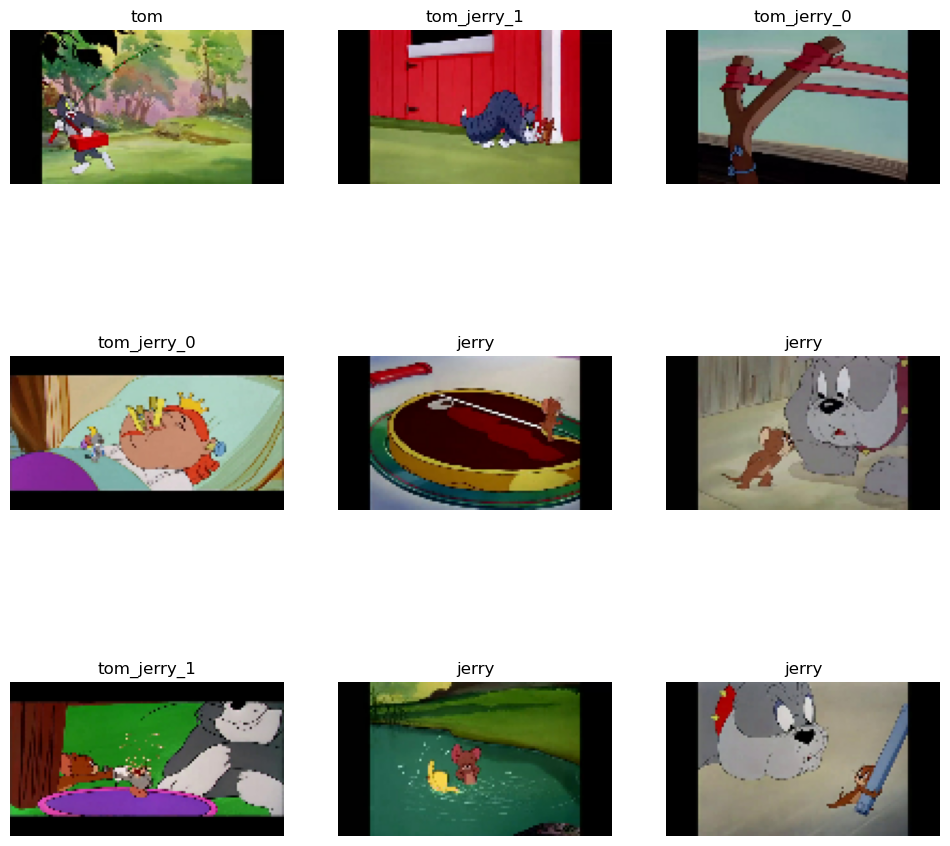

In [ ]:
# plot 16 examples from different classes

plt.figure(figsize=(12, 12))
for images, labels in train_data:
  # capture image, label pairs to plot
  for i in range(9):
    # want 16 image, label pairs
    ax = plt.subplot(3, 3, i + 1)
    # 4x4 subplot, 16 total images, iterate over plot location index
    plt.imshow(images[i].numpy().astype("uint8"))
    # .numpy() converts the tensor to a numpy array
    # convert array of pixels into displayable image
    # Most often this is used for arrays representing images, with the 3 color channels having small integer values (0 to 255).
    # https://stackoverflow.com/questions/68387192/what-is-np-uint8#:~:text=uint8%3A%208%2Dbit%20unsigned%20integer,values%20(0%20to%20255).

    plt.title(class_names[labels[i]])
    # remove axis, number lines add no info in image plots
    plt.axis(False)

# A Tensor is a multi-dimensional array that can be used to represent numerical data. In Tensorflow 2.0, a Tensor is an object that represents the inputs and outputs of a computation graph.
# EagerTensors are used in Tensorflow 2.0’s eager execution mode, which allows for more interactive and intuitive development
# https://saturncloud.io/blog/what-is-the-utility-of-tensor-as-opposed-to-eagertensor-in-tensorflow-20/#:~:text=A%20Tensor%20is%20a%20multi,is%20evaluated%20immediately%20upon%20creation.
type(images[i])

In [ ]:
# tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE. While the input pipeline is running, tf.data tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.
# https://stackoverflow.com/questions/56613155/tensorflow-tf-data-autotune
autotune = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
# https://www.tensorflow.org/tutorials/images/classification
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=autotune)
# Dataset.prefetch overlaps data preprocessing and model execution while training.
val_data = val_data.cache().prefetch(buffer_size=autotune)

# Quick guide on convolutional neural networks
#### - Primarily used in image processing
#### - Higher level neurons react to more complex patterns in images that combine simpler patterns from previous neurons. Ex: The first neuron may detect a horizontal line, while the second neuron detects a vertical line, the next neuron may detect a corner or some other more complex pattern
#### - Convolutional layers use partially connected layers to overcome the neuron restriction issue in a fully connected deep neural network

# CNN Image Processing

#### - Neurons in the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields. Each neuron in the second convolutional layer is connected ONLY to neurons located within a small rectangle in the first layer. This architecture allows the network to concentrate on small low-level features in their first hidden layer, then assemble them into larger higher-level features in the next hidden layer. That pattern continues between each convolutional layer.
######  - from class textbook



In [ ]:
# get number of classes to feed into Dense layer
num_classes = len(class_names)

# initialize Keras sequential model
model = Sequential([
  # rescale RGB channel from (0,255) to (0,1)
  # improves neural net performance, prefers smaller numbers
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # first convolutional layer
  # first argument is the number of filters, 16 feature maps, this takes the RGB intensity at each location and transforms it into the intensity of each feature at each location
  # second argument is kernel size, "An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions." Need to experiment with this argument.
  # third argument is padding, which forces the inputs to be surrounded with enough zeros on all sides to ensure the output feature maps end up with the same size as the inputs
  # fourth argument is the activation function, "A neuron with a rectifier attached is called a rectified linear unit. For that reason, we might also call the rectifier function the ReLU activation or even the ReLU function. The ReLU activation can be defined in its own Activation layer, but most often you'll just include it as the activation function of Conv2D
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # pooling shrinks the input image in order to reduce computational load, memory usage, and chances of overfitting
  # a pooling neuron has no weights, it just aggregates the inputs using an aggregation function such as the max or mean
  # max pooling is most common type of pooling method
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  # A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  # first argument is units, which defines the size of the output from the dense layer
  layers.Dense(128, activation='relu'),
  # this provides the dense layer with how many classes it needs to predict to
  layers.Dense(num_classes)
])

In [ ]:
# observing weight matrices
# https://stackoverflow.com/questions/43715047/how-do-i-get-the-weights-of-a-layer-in-keras

for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'name': 'rescaling_7', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 72, 128, 3), 'scale': 0.00392156862745098, 'offset': 0.0} []
{'name': 'conv2d_21', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[[-0.09712665,  0.13526306,  0.04178455, -0.09311815,
          -0.07183553, -0.12763038, -0.1398834 , -0.12534754,
           0.18669027,  0.04864931,  0.15763056,  0.14845479,
           0.03156187, -

In [ ]:
# adam optimizer implements stochastic gradient descent
model.compile(optimizer='adam',
              # Computes the crossentropy loss between the labels and predictions.
              # -- from TF "Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers."
              # The from_logits=True attribute informs the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution. Therefore, the output layer in this case does not have a softmax activation function:
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# https://stackoverflow.com/questions/61060736/how-to-interpret-model-summary-output-in-cnn

# flatten layer before dense layer, dense expects a 1d array of features for each instance.
# The Flatten layer takes all pixels along all channels and creates a 1D vector (not considering batch size) (28 * 28 * 64 = 50176)
# https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/#:~:text=What%20is%20Flatten()%20in,and%20combining%20all%20other%20dimensions.&text=In%20this%20example%2C%20the%20Flatten,1D%20tensor%20with%20nine%20elements.

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 72, 128, 3)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 128, 16)       448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 36, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 36, 64, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 18, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 18, 32, 64)       

# Breakdown of what the output is telling us
#### - "The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated."
#### - "The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset."
   ###### https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
#### - there are 137 batches of 32 images in the training set, hence why it says 137/137
#### - loss is the cross entropy loss during training, val_loss is loss predicting new images
#### - if there is a large difference between loss and val_loss, it tells me that the model if OVERFITTING the training data


In [ ]:
epochs=10
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
137/137 [==============================] - 7s 51ms/step - loss: 1.2554 - accuracy: 0.4246 - val_loss: 1.0334 - val_accuracy: 0.5699
Epoch 2/10
137/137 [==============================] - 7s 48ms/step - loss: 0.9292 - accuracy: 0.6156 - val_loss: 0.6683 - val_accuracy: 0.7498
Epoch 3/10
137/137 [==============================] - 7s 48ms/step - loss: 0.6392 - accuracy: 0.7554 - val_loss: 0.4642 - val_accuracy: 0.8393
Epoch 4/10
137/137 [==============================] - 7s 48ms/step - loss: 0.4703 - accuracy: 0.8257 - val_loss: 0.3464 - val_accuracy: 0.9023
Epoch 5/10
137/137 [==============================] - 7s 49ms/step - loss: 0.3430 - accuracy: 0.8727 - val_loss: 0.3597 - val_accuracy: 0.8767
Epoch 6/10
137/137 [==============================] - 7s 48ms/step - loss: 0.2628 - accuracy: 0.9028 - val_loss: 0.2667 - val_accuracy: 0.9096
Epoch 7/10
137/137 [==============================] - 6s 47ms/step - loss: 0.2013 - accuracy: 0.9325 - val_loss: 0.2059 - val_accuracy: 0.9434

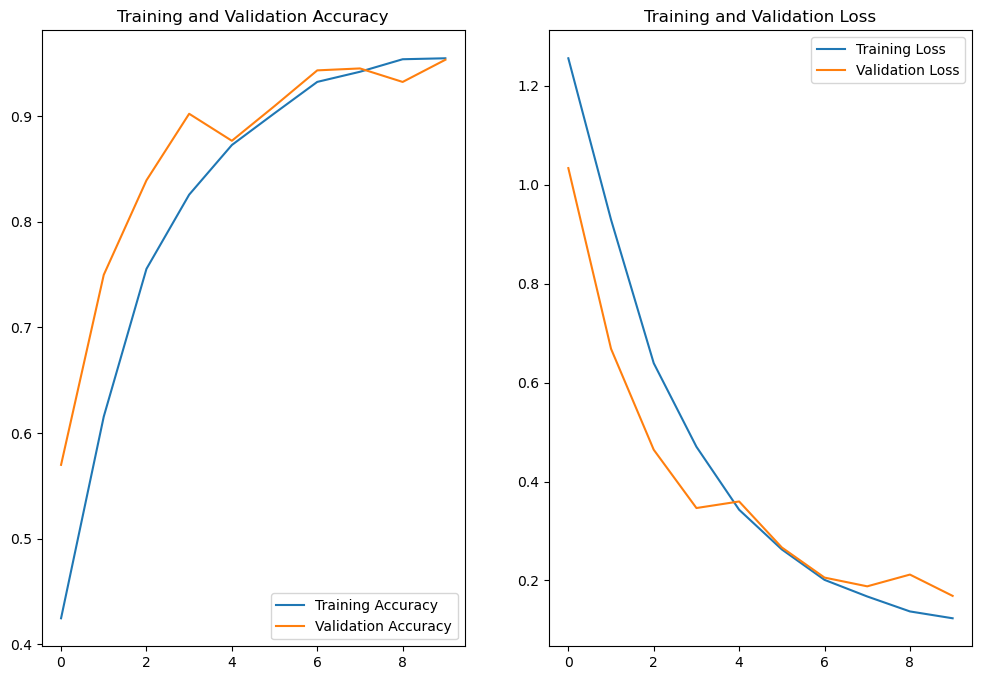

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

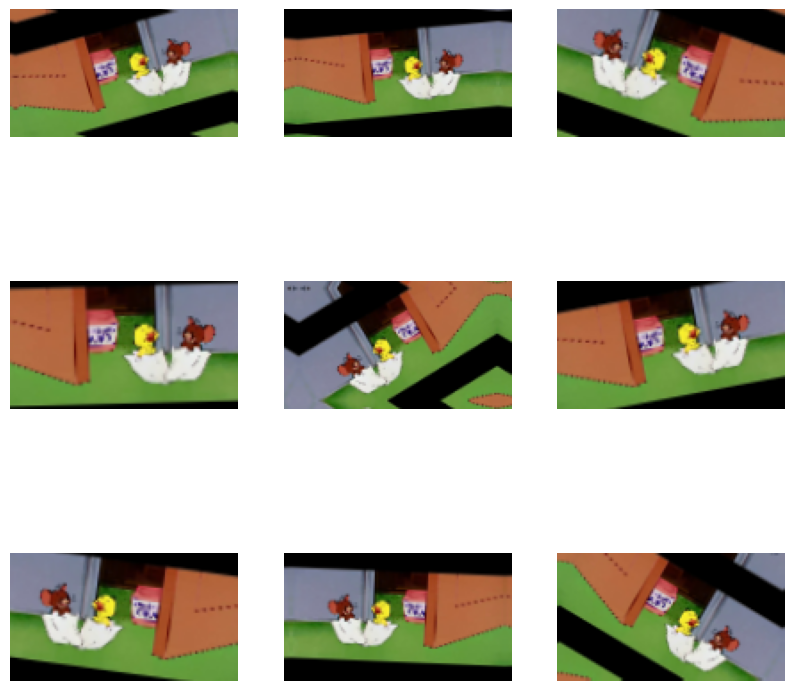

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 25
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/25
137/137 [==============================] - 8s 53ms/step - loss: 1.3218 - accuracy: 0.3609 - val_loss: 1.3275 - val_accuracy: 0.4237
Epoch 2/25
137/137 [==============================] - 7s 54ms/step - loss: 1.1830 - accuracy: 0.4668 - val_loss: 1.0350 - val_accuracy: 0.5352
Epoch 3/25
137/137 [==============================] - 8s 55ms/step - loss: 1.0216 - accuracy: 0.5451 - val_loss: 1.1165 - val_accuracy: 0.5498
Epoch 4/25
137/137 [==============================] - 8s 55ms/step - loss: 0.9380 - accuracy: 0.5882 - val_loss: 0.8991 - val_accuracy: 0.6037
Epoch 5/25
137/137 [==============================] - 7s 54ms/step - loss: 0.8465 - accuracy: 0.6336 - val_loss: 0.7980 - val_accuracy: 0.6612
Epoch 6/25
137/137 [==============================] - 7s 54ms/step - loss: 0.8108 - accuracy: 0.6557 - val_loss: 0.8516 - val_accuracy: 0.6530
Epoch 7/25
137/137 [==============================] - 7s 53ms/step - loss: 0.7669 - accuracy: 0.6749 - val_loss: 0.6734 - val_accuracy: 0.7105

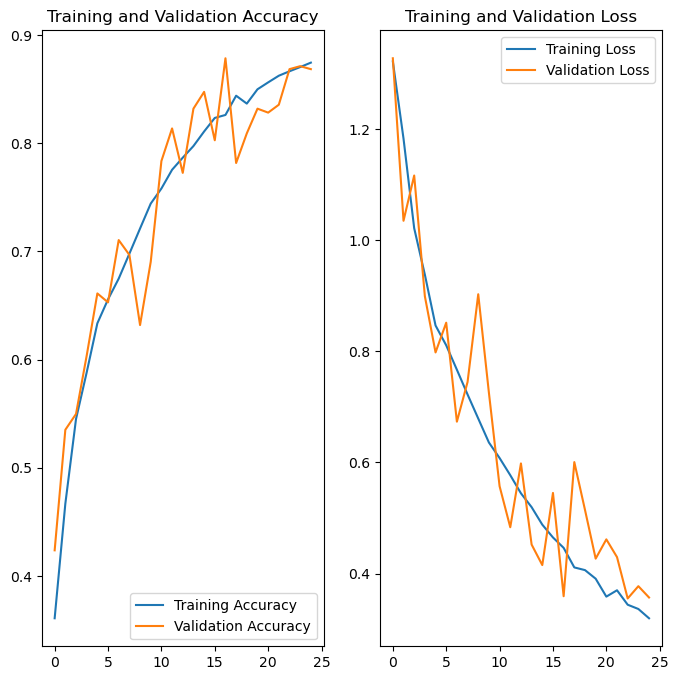

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()